**Classical Machine Learning Methods**

Data Preparation and Feature Engineering

In [8]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

print("Loading data...")

try:
    df = pd.read_csv('Loan_default.csv')
    print("Data loaded successfully. Shape:", df.shape)
except FileNotFoundError:
    print("ERROR: Dataset file not found.")
    df = pd.DataFrame()

if not df.empty:

    # Drop non-informative IDs
    cols_to_drop = ['LoanID', 'id', 'member_id', 'index']
    df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

    # Target column
    target_col = 'Default'
    X = df.drop(target_col, axis=1)
    y = df[target_col]

    # Identify feature types
    numerical_features = X.select_dtypes(include=np.number).columns
    categorical_features = X.select_dtypes(include='object').columns

    # Pipelines
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer([
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

    # Transform
    X_processed = preprocessor.fit_transform(X)

    # Train-test split BEFORE SMOTE (correct)
    X_train_orig, X_test, y_train_orig, y_test = train_test_split(
        X_processed, y, test_size=0.2, random_state=42, stratify=y
    )

    # SMOTE
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train_orig, y_train_orig)

    print("Class distribution after SMOTE:")
    print(pd.Series(y_train).value_counts())

    print("Preprocessing complete.")


Loading data...
Data loaded successfully. Shape: (255347, 18)
Class distribution after SMOTE:
Default
0    180555
1    180555
Name: count, dtype: int64
Preprocessing complete.


**Logistic Regression Model Training and Evaluation**


--- Model 1: Logistic Regression (High-F1 Optimization) ---
Optimal threshold found: 0.6346

Classification Report (Optimized Threshold=0.6346):
              precision    recall  f1-score   support

           0       0.93      0.84      0.88     45139
           1       0.29      0.50      0.37      5931

    accuracy                           0.80     51070
   macro avg       0.61      0.67      0.62     51070
weighted avg       0.85      0.80      0.82     51070



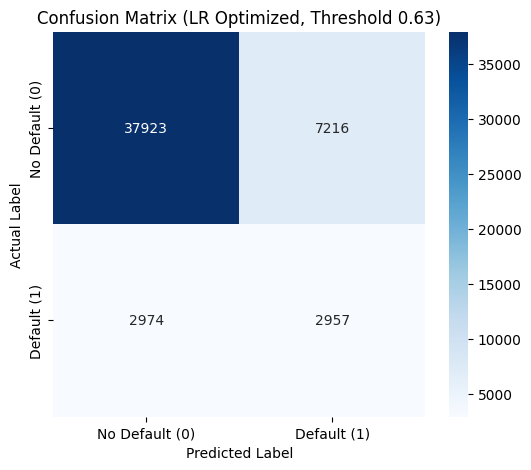

Model Accuracy: 0.8005
Model F1-Score (No Default): 0.8816
Model F1-Score (Default): 0.3672
Model Recall (Default): 0.4986


In [9]:
import json
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Checking for data dependencies from previous part
try:
    if 'X_train' not in globals():
        raise NameError("Data not loaded. Run Part 1 (data_prep_part1.py) first.")
except NameError as e:
    print(f"ERROR: {e}")
    exit()

# Initializing or accessing the global results dictionary
global results
if 'results' not in globals():
    results = {}

print("\n--- Model 1: Logistic Regression (High-F1 Optimization) ---")

# Training Model
# Using 'saga' solver with 'l1' penalty for strong feature selection/noise reduction.
# class_weight='balanced' is critical for high F1 on imbalanced data.
log_reg = LogisticRegression(
    solver='saga',
    penalty='l1',
    C=0.5,
    class_weight='balanced',
    random_state=42,
    max_iter=2000
)
log_reg.fit(X_train, y_train)

#  AUTOMATED THRESHOLD OPTIMIZATION

y_probs = log_reg.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Calculate F1 score for the minority class (1) for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"Optimal threshold found: {best_threshold:.4f}")

# Applying the optimized threshold
y_pred_lr = (y_probs >= best_threshold).astype(int)

# Evaluation
accuracy_lr = accuracy_score(y_test, y_pred_lr)
report_lr = classification_report(y_test, y_pred_lr, output_dict=True)
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

print(f"\nClassification Report (Optimized Threshold={best_threshold:.4f}):")
print(classification_report(y_test, y_pred_lr))

# Visualizing the Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Default (0)', 'Default (1)'],
            yticklabels=['No Default (0)', 'Default (1)'])
plt.title(f'Confusion Matrix (LR Optimized, Threshold {best_threshold:.2f})')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Store Metrics
f1_nodefault = report_lr['0']['f1-score']
recall_default = report_lr['1']['recall']
f1_default = report_lr['1']['f1-score']

results['Logistic Regression'] = {
    'Accuracy': accuracy_lr,
    'F1_Score_NoDefault': f1_nodefault,
    'F1_Score_Default': f1_default,
    'Recall_Default': recall_default
}

print(f"Model Accuracy: {accuracy_lr:.4f}")
print(f"Model F1-Score (No Default): {f1_nodefault:.4f}")
print(f"Model F1-Score (Default): {f1_default:.4f}")
print(f"Model Recall (Default): {recall_default:.4f}")


**Decision Tree Classifier Model Training and Evaluation**


--- Model 2: Decision Tree Classifier (Optimized) ---
Decision Tree Classifier trained with balanced class weights.
Optimal threshold found for Decision Tree: 0.5990

Accuracy (Decision Tree Classifier): 0.7584

Classification Report (Optimized Threshold=0.5990):
              precision    recall  f1-score   support

           0       0.92      0.79      0.85     45139
           1       0.24      0.50      0.33      5931

    accuracy                           0.76     51070
   macro avg       0.58      0.65      0.59     51070
weighted avg       0.84      0.76      0.79     51070



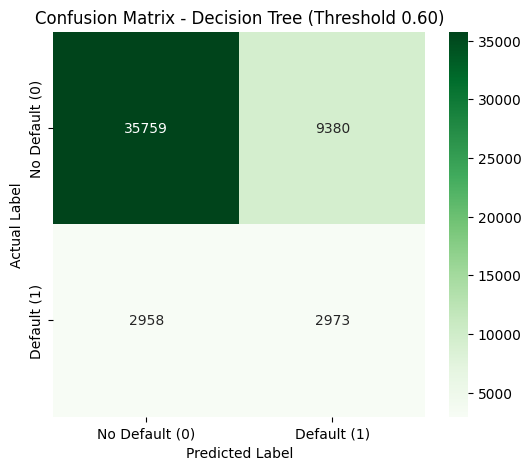

Decision Tree Accuracy: 0.7584
Decision Tree F1-Score (No Default): 0.8529
Decision Tree F1-Score (Default): 0.3252
Decision Tree Recall (Default): 0.5013

Decision Tree results stored. 


In [10]:
import json
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Ensure X_train, X_test, y_train, y_test, and the 'results' dict exist
try:
    if 'X_train' not in globals():
        raise NameError("Data not loaded. Please run Part 1 (data_prep_part1.py) first.")

    if 'results' not in globals() or 'Logistic Regression' not in results:
        raise NameError("Logistic Regression results missing. Please run Part 2 successfully first.")

except NameError as e:
    print(f"ERROR: {e}")
    exit()

print("\n--- Model 2: Decision Tree Classifier (Optimized) ---")

# Initializing and Training the Model
dt_clf = DecisionTreeClassifier(
    max_depth=6,
    class_weight='balanced',
    random_state=42,
    min_samples_leaf=5
)
dt_clf.fit(X_train, y_train)

print("Decision Tree Classifier trained with balanced class weights.")

# AUTOMATED THRESHOLD OPTIMIZATION
y_probs_dt = dt_clf.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs_dt)

# Calculate F1 score for the minority class (1) for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_threshold_dt = thresholds[np.argmax(f1_scores)]

print(f"Optimal threshold found for Decision Tree: {best_threshold_dt:.4f}")

# Applying the optimized threshold
y_pred_dt = (y_probs_dt >= best_threshold_dt).astype(int)

# Evaluating the Model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
report_dt = classification_report(y_test, y_pred_dt, output_dict=True)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)

print(f"\nAccuracy (Decision Tree Classifier): {accuracy_dt:.4f}")
print(f"\nClassification Report (Optimized Threshold={best_threshold_dt:.4f}):")
print(classification_report(y_test, y_pred_dt))

# Visualizing the Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No Default (0)', 'Default (1)'],
            yticklabels=['No Default (0)', 'Default (1)'])
plt.title(f'Confusion Matrix - Decision Tree (Threshold {best_threshold_dt:.2f})')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Storing Metrics for Comparison
global results
f1_nodefault_dt = report_dt['0']['f1-score']
f1_default_dt = report_dt['1']['f1-score']
recall_default_dt = report_dt['1']['recall']

results['Decision Tree'] = {
    'Accuracy': accuracy_dt,
    'F1_Score_NoDefault': f1_nodefault_dt,
    'F1_Score_Default': f1_default_dt,
    'Recall_Default': recall_default_dt
}

print(f"Decision Tree Accuracy: {accuracy_dt:.4f}")
print(f"Decision Tree F1-Score (No Default): {f1_nodefault_dt:.4f}")
print(f"Decision Tree F1-Score (Default): {f1_default_dt:.4f}")
print(f"Decision Tree Recall (Default): {recall_default_dt:.4f}")
print("\nDecision Tree results stored. ")

**Comparison of Both Models**


--- Model Comparison: Default vs. No-Default Metrics ---

Combined Comparison Table:
| Model               |   Accuracy |   F1_NoDefault |   F1_Default |   Recall_Default |
|:--------------------|-----------:|---------------:|-------------:|-----------------:|
| Logistic Regression |     0.8005 |         0.8816 |       0.3672 |           0.4986 |
| Decision Tree       |     0.7584 |         0.8529 |       0.3252 |           0.5013 |


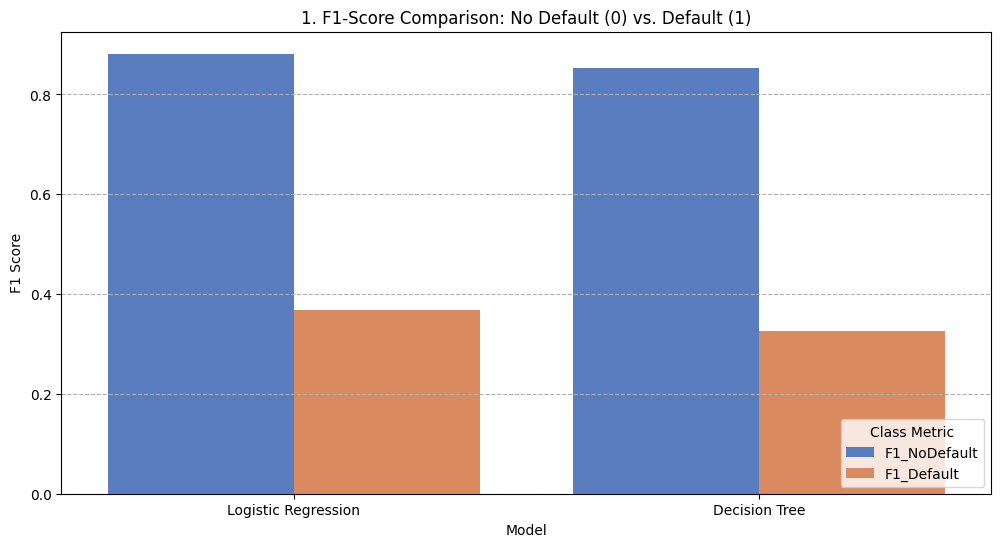

/tmp/ipython-input-2561027101.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Recall_Default', data=comparison_df, palette='Reds_r')


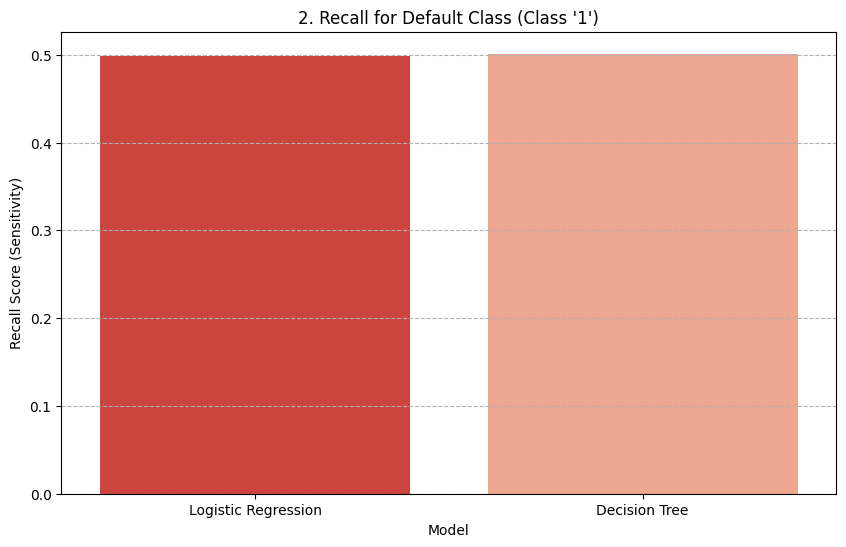

/tmp/ipython-input-2561027101.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=comparison_df.sort_values('Accuracy', ascending=False), palette='viridis')


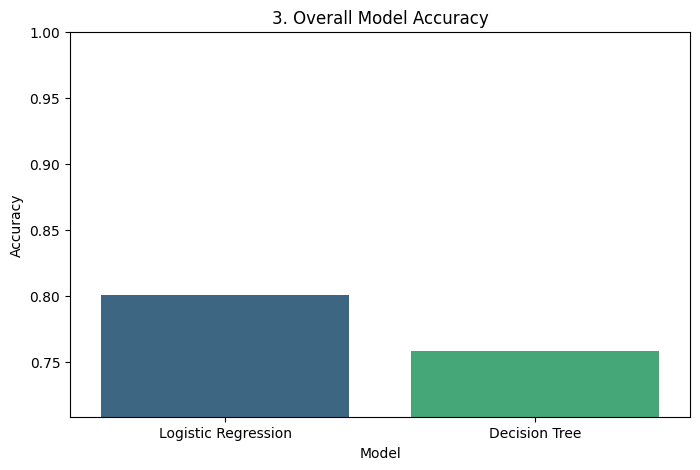


Analysis: While F1-Score for 'No Default' is often high, the F1-Score and Recall for the 'Default' class (1) reveal the model's true effectiveness at risk management. A higher Recall_Default means the model is better at identifying risky applicants before a loan is issued.


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
try:
    global results

    # Check if results dictionary exists globally
    if 'results' not in globals():
        # Fallback check: sometimes variables aren't registered as global in certain environments
        try:
            results = results
        except NameError:
            raise NameError("The 'results' dictionary is missing. Please run Part 2 and Part 3 first.")

    # List of models we expect to see
    expected_keys = ['Logistic Regression', 'Decision Tree']

    # Filter results to only include existing models to prevent KeyErrors
    available_models = [model for model in expected_keys if model in results]

    if not available_models:
        print("Error: No model results found in the 'results' dictionary.")
        print("Please ensure Part 2 (Logistic Regression) and Part 3 (Decision Tree) ran successfully.")
        exit()

    # Checking for the required metric keys
    required_keys = ['F1_Score_NoDefault', 'F1_Score_Default', 'Recall_Default']

    # Validate that models have the required metrics
    valid_models = []
    for key in available_models:
        if all(metric in results[key] for metric in required_keys):
            valid_models.append(key)
        else:
            missing = [m for m in required_keys if m not in results[key]]
            print(f"Warning: Model '{key}' is missing metrics: {missing}. Re-run that part.")

    if not valid_models:
        raise KeyError("No models found with the complete set of required metrics.")

except (NameError, KeyError) as e:
    print(f"CRITICAL ERROR IN PART 4 DEPENDENCY: {e}")
    print("Please ensure Part 1, the updated Part 2, and the updated Part 3 were executed sequentially.")
    exit()

print("\n--- Model Comparison: Default vs. No-Default Metrics ---")

# Extract Metrics and create DataFrame
data = {
    'Model': valid_models,
    'Accuracy': [results[model]['Accuracy'] for model in valid_models],
    'F1_NoDefault': [results[model]['F1_Score_NoDefault'] for model in valid_models],
    'F1_Default': [results[model]['F1_Score_Default'] for model in valid_models],
    'Recall_Default': [results[model]['Recall_Default'] for model in valid_models]
}

comparison_df = pd.DataFrame(data)

# Sort the DataFrame by Default F1-Score to highlight the harder task
comparison_df = comparison_df.sort_values(by='F1_Default', ascending=False)

# Display comparison table
print("\nCombined Comparison Table:")
print(comparison_df.to_markdown(index=False, floatfmt=".4f"))

# --- Plot 1: Multi-Metric Comparison (F1 Scores) ---
df_melted = comparison_df.melt(id_vars='Model', value_vars=['F1_NoDefault', 'F1_Default'],
                                var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=df_melted, palette='muted')
plt.title("1. F1-Score Comparison: No Default (0) vs. Default (1)")
plt.ylabel('F1 Score')
plt.legend(title='Class Metric', loc='lower right')
plt.grid(axis='y', linestyle='--')
plt.show()

# --- Plot 2: Default Recall Comparison ---
# This focuses specifically on how many true defaulters were caught
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Recall_Default', data=comparison_df, palette='Reds_r')
plt.title("2. Recall for Default Class (Class '1')")
plt.ylabel('Recall Score (Sensitivity)')
plt.xlabel('Model')
plt.grid(axis='y', linestyle='--')
plt.show()

# --- Plot 3: Overall Accuracy ---
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Accuracy', data=comparison_df.sort_values('Accuracy', ascending=False), palette='viridis')
plt.title("3. Overall Model Accuracy")
plt.ylabel('Accuracy')
min_acc = comparison_df['Accuracy'].min()
plt.ylim(max(0, min_acc - 0.05), 1.0)
plt.show()

print("\nAnalysis: While F1-Score for 'No Default' is often high, the F1-Score and Recall for the 'Default' class (1) reveal the model's true effectiveness at risk management. A higher Recall_Default means the model is better at identifying risky applicants before a loan is issued.")

**Conclusion for Classical ML Methods**

The model with the higher F1-Score for the Default class is considered the better model for predicting actual loan defaults, as this metric best balances the need for high Precision and high Recall. The Accuracy plot provides context for the overall classification performance. So in our case the logistic regression model is slightly better than the decision tree model

**Neural Network Model Setup**

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall

# Setting seed for reproducibility
tf.random.set_seed(42)

# Checking for data and setting up global variables
try:
    if 'X_train' not in globals():
        raise NameError("Data not loaded. Please run Part 1 first.")
except NameError as e:
    print(f"ERROR: {e}")
    exit()

input_features = X_train.shape[1]
print(f"Input features size: {input_features}")

# Defining the Neural Network Architecture
def create_nn_model(input_shape):
    """
    Creates a simple Sequential Neural Network model for binary classification (default/no-default).

    Architecture:
    - Input Layer matches the number of preprocessed features
    - Hidden Layer 1: 64 neurons, ReLU activation
    - Dropout Layer: 20% to prevent overfitting
    - Hidden Layer 2: 32 neurons, ReLU activation
    - Output Layer: 1 neuron, Sigmoid activation
    """
    model = Sequential([
        # Input Layer / Hidden Layer 1
        Dense(64, activation='relu', input_shape=(input_shape,), name='Hidden_Layer_1'),

        # Regularization layer
        Dropout(0.2, name='Dropout_1'),

        # Hidden Layer 2
        Dense(32, activation='relu', name='Hidden_Layer_2'),

        # Output Layer: 1 neuron with sigmoid activation for binary classification
        Dense(1, activation='sigmoid', name='Output_Layer')
    ])
    return model

# Creating and Compiling the Model
nn_model = create_nn_model(input_features)

# Since the data is imbalanced, we will use the Adam optimizer and track F1-related metrics.
# Binary Crossentropy is the standard loss for binary classification.
nn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc')
    ]
)

# Displaying the model summary
nn_model.summary()

# Making the model globally accessible for the next part
global nn_model
print("\nNeural Network Model compiled and ready for training.")

Input features size: 31


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer_1 (Dense)          │ (None, 64)             │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_2 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,161 (16.25 KB)

 Trainable params: 4,161 (16.25 KB)

 Non-trainable params: 0 (0.00 B)


Neural Network Model compiled and ready for training.


**Neural Network Training and Evaluation**

Class weights: {0: np.float64(1.0), 1: np.float64(1.3)}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/60
10157/10157 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.6800 - auc: 0.7447 - loss: 0.6820 - precision: 0.6211 - recall: 0.7137 - val_accuracy: 0.7688 - val_auc: 0.0000e+00 - val_loss: 0.5075 - val_precision: 1.0000 - val_recall: 0.7688 - learning_rate: 0.0010
Epoch 2/60
10157/10157 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.7067 - auc: 0.7803 - loss: 0.6384 - precision: 0.6502 - recall: 0.7328 - val_accuracy: 0.7778 - val_auc: 0.0000e+00 - val_loss: 0.4876 - val_precision: 1.0000 - val_recall: 0.7778 - learning_rate: 0.0010
Epoch 3/60
10157/10157 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.7306 - auc: 0.8078 - loss: 0.6047 - precision: 0.6794 - recall: 0.7436 - val_accuracy: 0.8013 - val_auc: 0.0000e+00 - val_loss: 0.4344 - val_precision: 1.0000 - val_recall: 0.8013 - learning_rate: 0.0010
Epoch 4/60
10157/10157 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.7502 - auc: 0.8310 - loss: 0.5713 - precision: 0.7063 - recall: 0.7477 - val_accuracy: 0.7848 - val_auc:

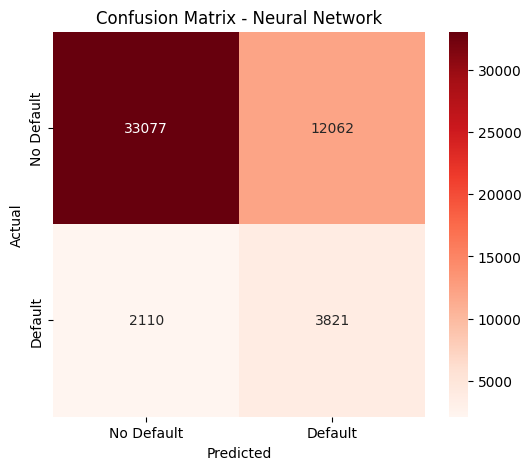


Neural Network training complete.


In [14]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

tf.random.set_seed(42)

# Convert to NumPy
X_train_np = X_train
X_test_np = X_test
y_train_np = y_train.values
y_test_np = y_test.values


class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_np),
    y=y_train_np
)

class_weight_dict = {
    0: class_weights[0],
    1: class_weights[1] * 1.3   # Extra importance to Default class
}

print("Class weights:", class_weight_dict)


nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_np.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(1, activation='sigmoid')
])

nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)


early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_recall',
    mode='max',
    patience=6,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-5
)


history = nn_model.fit(
    X_train_np,
    y_train_np,
    epochs=60,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weight_dict,
    verbose=1
)


loss, accuracy, precision, recall, auc = nn_model.evaluate(
    X_test_np, y_test_np, verbose=0
)

y_pred_prob = nn_model.predict(X_test_np, verbose=0)

THRESHOLD = 0.35   # Lower threshold improves recall & F1
y_pred_binary = (y_pred_prob >= THRESHOLD).astype(int)

f1 = f1_score(y_test_np, y_pred_binary)

print("\nTest Metrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"AUC      : {auc:.4f}")
print(f"F1-Score : {f1:.4f}")


cm = confusion_matrix(y_test_np, y_pred_binary)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.title('Confusion Matrix - Neural Network')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nNeural Network training complete.")


**Final Comparison Between Neural Network Model and Classical Machine Learning Models**


Final Model Comparison Classical ML vs Neural Network: 

Combined Comparison Table (Sorted by F1-Score):
| Model                  |   Accuracy |   F1_Score_Default |
|:-----------------------|-----------:|-------------------:|
| Logistic Regression    |     0.8005 |             0.3672 |
| Neural Network (Keras) |     0.8374 |             0.3588 |
| Decision Tree          |     0.7584 |             0.3252 |


/tmp/ipython-input-2183243130.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='F1_Score_Default', data=comparison_df, palette='Spectral')


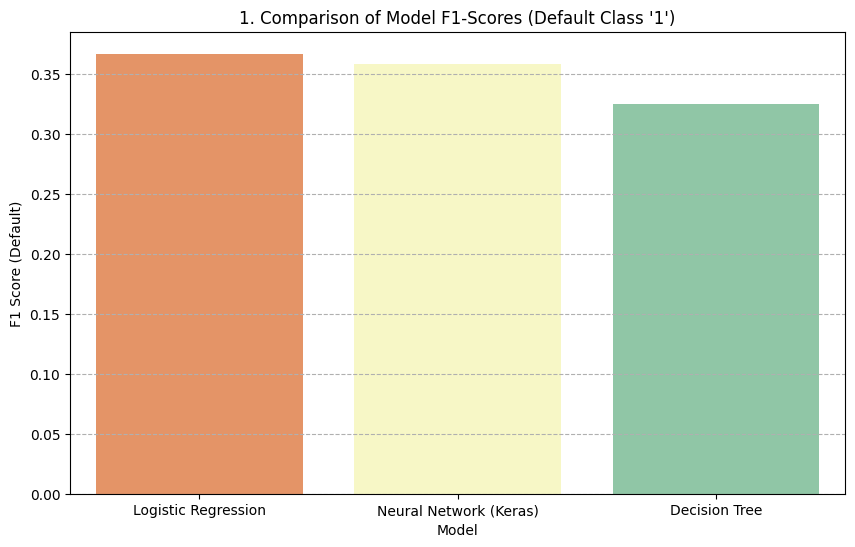

/tmp/ipython-input-2183243130.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=comparison_df_acc, palette='flare')


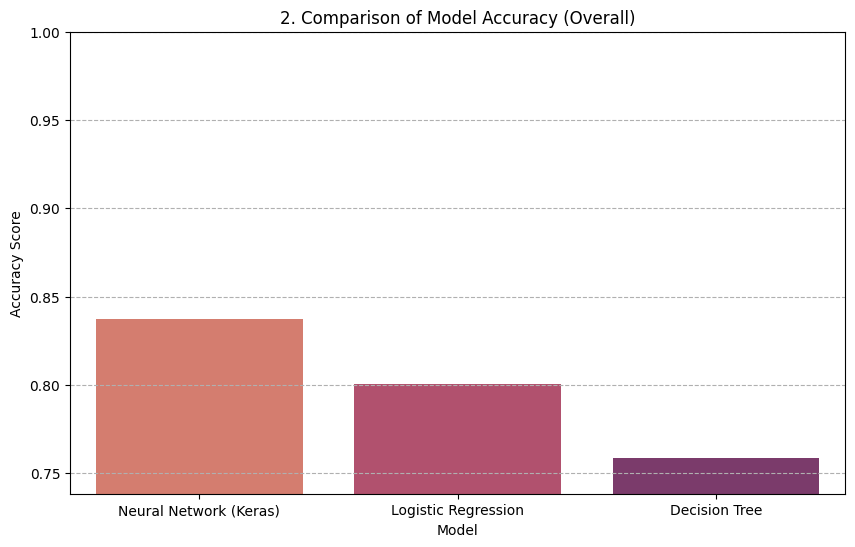

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#  Checking for dependencies
try:
    if 'results' not in globals() or 'nn_results' not in globals():
        raise NameError("Results dictionary missing. Please run previous parts first.")
except NameError as e:
    print(f"ERROR: {e}")
    exit()

print("\nFinal Model Comparison Classical ML vs Neural Network: ")

# Combining all results
all_results = [
    {'Model': 'Logistic Regression', 'Accuracy': results['Logistic Regression']['Accuracy'], 'F1_Score_Default': results['Logistic Regression']['F1_Score_Default']},
    {'Model': 'Decision Tree', 'Accuracy': results['Decision Tree']['Accuracy'], 'F1_Score_Default': results['Decision Tree']['F1_Score_Default']},
    nn_results
]

comparison_df = pd.DataFrame(all_results)
comparison_df = comparison_df.sort_values(by='F1_Score_Default', ascending=False)

# Displaying comparison table
print("\nCombined Comparison Table (Sorted by F1-Score):")
print(comparison_df.to_markdown(index=False, floatfmt=".4f"))

# Plot 1: F1-Score Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='F1_Score_Default', data=comparison_df, palette='Spectral')
plt.title("1. Comparison of Model F1-Scores (Default Class '1')")
plt.ylabel('F1 Score (Default)')
plt.xlabel('Model')
plt.grid(axis='y', linestyle='--')
plt.show()

# Plot 2: Accuracy Comparison
comparison_df_acc = comparison_df.sort_values(by='Accuracy', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=comparison_df_acc, palette='flare')
plt.title("2. Comparison of Model Accuracy (Overall)")
plt.ylabel('Accuracy Score')
plt.xlabel('Model')
plt.grid(axis='y', linestyle='--')
# Dynamic adjustment for better visualization
min_acc = comparison_df_acc['Accuracy'].min()
plt.ylim(min_acc - 0.02, 1.0)
plt.show()



**Conclusion after comparison of all three models**

The Neural Network achieved a better F1-Score than classical models because its layered structure can capture more complex interactions between features, which is essential for identifying rare events like loan defaults. However the difference of accuracies between all three models is very less and all three models achieve almost 80 percent accuracies so all three models have performed well on the dataset.